In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  # For player detection

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def create_birds_eye_view(frame, court_corners=None):
    """
    Convert a basketball court frame to a birds-eye view with player positions mapped.

    Args:
    frame: The input video frame (numpy array)
    court_corners: Optional list of 4 points defining the court corners in the frame. If None, will prompt user to select corners.

    Returns:
    A birds-eye view visualization of the court with player positions
    """
    # Make a copy of the frame to work with
    img = frame.copy()
    h, w = img.shape[:2]

    # Step 1: Define the court corners if not provided
    if court_corners is None:
        # Currently, we just use a default court rectangle
        # However, we should use a more sophisticated approach like court line detection or allow the user to mark the corners manually
        court_corners = np.array([
            [int(w * 0.2), int(h * 0.15)],  # Top-left
            [int(w * 0.8), int(h * 0.15)],  # Top-right
            [int(w * 0.8), int(h * 0.85)],  # Bottom-right
            [int(w * 0.2), int(h * 0.85)]   # Bottom-left
        ], dtype=np.float32)

    # Step 2: Define the destination points for the birds-eye view
    # Standard basketball court dimensions: 94 feet x 50 feet
    court_width = 500
    court_height = 940

    dst_points = np.array([
        [0, 0],
        [court_width, 0],
        [court_width, court_height],
        [0, court_height]
    ], dtype=np.float32)

    # Step 3: Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(court_corners, dst_points)

    # Step 4: Detect players using YOLO
    model = YOLO('yolov8n.pt')
    results = model(img)

    # Filter for person class (class 0 in COCO dataset)
    boxes = []
    for result in results:
        detections = result.boxes
        for i, box in enumerate(detections):
            cls = int(box.cls.item())
            if cls == 0:  # Person class
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                boxes.append([int(x1), int(y1), int(x2), int(y2)])

    # Step 5: Get player positions (bottom center of bounding boxes)
    player_positions = []
    for box in boxes:
        x1, y1, x2, y2 = box
        # Bottom center point of the bounding box
        foot_position = [int((x1 + x2) / 2), y2]
        player_positions.append(foot_position)

    # Step 6: Create a birds-eye view
    court_img = np.ones((court_height, court_width, 3), dtype=np.uint8) * 255

    # Draw court lines (simplified)
    # Outer boundary
    cv2.rectangle(court_img, (0, 0), (court_width, court_height), (0, 0, 0), 2)

    # Half-court line
    cv2.line(court_img, (0, court_height // 2), (court_width, court_height // 2), (0, 0, 0), 2)

    # Center circle
    center_x, center_y = court_width // 2, court_height // 2
    cv2.circle(court_img, (center_x, center_y), 60, (0, 0, 0), 2)

    # Free throw circles and lines
    # Top
    cv2.circle(court_img, (center_x, int(court_height * 0.15)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.15)),
             (int(court_width * 0.75), int(court_height * 0.15)), (0, 0, 0), 2)

    # Bottom
    cv2.circle(court_img, (center_x, int(court_height * 0.85)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.85)),
             (int(court_width * 0.75), int(court_height * 0.85)), (0, 0, 0), 2)

    # Step 7: Transform player positions to birds-eye view coordinates
    birds_eye_positions = []
    for pos in player_positions:
        # Add a 1 for homogeneous coordinates
        pos_homogeneous = np.array([pos[0], pos[1], 1])

        # Apply perspective transformation
        transformed = M.dot(pos_homogeneous)

        # Normalize
        transformed = transformed / transformed[2]
        birds_eye_positions.append((int(transformed[0]), int(transformed[1])))

    # Step 8: Draw players on the birds-eye view
    for i, pos in enumerate(birds_eye_positions):
        # Skip players outside the court
        if (0 <= pos[0] < court_width and 0 <= pos[1] < court_height):
            # Draw as a circle
            cv2.circle(court_img, pos, 10, (255, 0, 0), -1)  # Blue circles for players

            # Add player number
            cv2.putText(court_img, str(i+1), pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Draw the original frame with detected players for reference
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        foot_position = [int((x1 + x2) / 2), y2]
        cv2.circle(img, tuple(foot_position), 5, (0, 0, 255), -1)

    return img, court_img


0: 416x640 13 persons, 342.8ms
Speed: 7.3ms preprocess, 342.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)


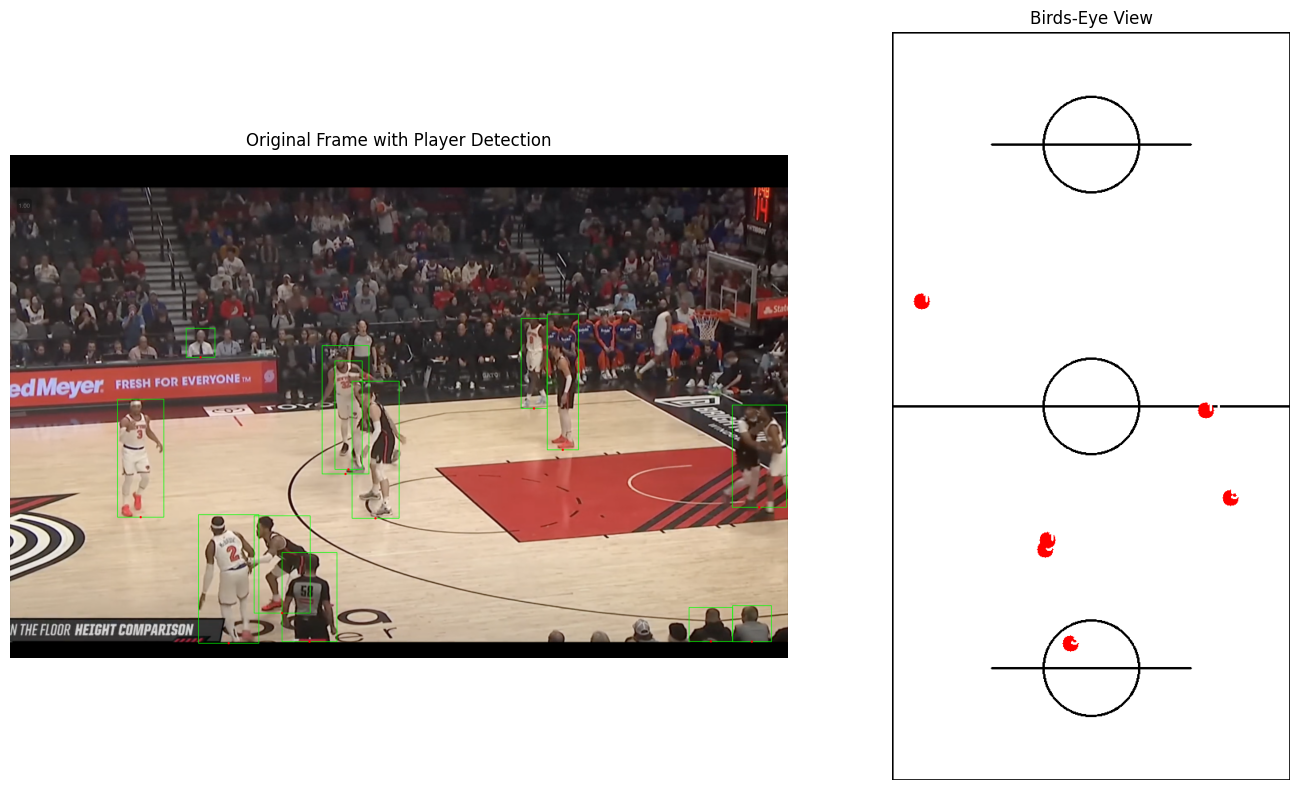

True

In [ ]:
# 1. Load a video frame
frame = cv2.imread('basketball_frame.png')

# 2. Process the frame
original_with_detection, birds_eye = create_birds_eye_view(frame)

# 3. Display results
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title('Original Frame with Player Detection')
plt.imshow(cv2.cvtColor(original_with_detection, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Birds-Eye View')
plt.imshow(birds_eye)
plt.axis('off')

plt.tight_layout()
plt.show()

# Save output images
cv2.imwrite('player_detection.jpg', original_with_detection)
cv2.imwrite('birds_eye_view.jpg', birds_eye)

In [ ]:


# def create_birds_eye_view(frame, court_corners=None):
#     """
#     Convert a basketball court frame to a birds-eye view with player positions mapped.

#     Args:
#         frame: The input video frame (numpy array)
#         court_corners: Optional list of 4 points defining the court corners in the frame.
#                       If None, will prompt user to select corners.

#     Returns:
#         A birds-eye view visualization of the court with player positions
#     """
#     # Make a copy of the frame to work with
#     img = frame.copy()
#     h, w = img.shape[:2]

#     # Step 1: Define the court corners if not provided
#     if court_corners is None:
#         # For simplicity, we'll use a default court rectangle
#         # In practice, you would use a more sophisticated approach like court line detection
#         # or allow the user to mark the corners manually
#         court_corners = np.array([
#             [int(w * 0.2), int(h * 0.15)],  # Top-left
#             [int(w * 0.8), int(h * 0.15)],  # Top-right
#             [int(w * 0.8), int(h * 0.85)],  # Bottom-right
#             [int(w * 0.2), int(h * 0.85)]   # Bottom-left
#         ], dtype=np.float32)

#     # Step 2: Define the destination points for the birds-eye view
#     # Standard basketball court dimensions: 94 feet x 50 feet
#     court_width = 500    # Width in pixels for our birds-eye view
#     court_height = 940   # Height in pixels for our birds-eye view

#     dst_points = np.array([
#         [0, 0],
#         [court_width, 0],
#         [court_width, court_height],
#         [0, court_height]
#     ], dtype=np.float32)

#     # Step 3: Calculate the perspective transform matrix
#     M = cv2.getPerspectiveTransform(court_corners, dst_points)

#     # Step 4: Detect players using YOLO
#     model = YOLO('yolov8n.pt')  # Load a pre-trained YOLO model
#     results = model(img)

#     # Filter for person class (class 0 in COCO dataset)
#     boxes = []
#     for result in results:
#         detections = result.boxes
#         for i, box in enumerate(detections):
#             cls = int(box.cls.item())
#             if cls == 0:  # Person class
#                 x1, y1, x2, y2 = box.xyxy[0].tolist()
#                 boxes.append([int(x1), int(y1), int(x2), int(y2)])

#     # Step 5: Get player positions (bottom center of bounding boxes)
#     player_positions = []
#     for box in boxes:
#         x1, y1, x2, y2 = box
#         # Bottom center point of the bounding box
#         foot_position = [int((x1 + x2) / 2), y2]
#         player_positions.append(foot_position)

#     # Step 6: Create a birds-eye view
#     court_img = np.ones((court_height, court_width, 3), dtype=np.uint8) * 255

#     # Draw court lines (simplified)
#     # Outer boundary
#     cv2.rectangle(court_img, (0, 0), (court_width, court_height), (0, 0, 0), 2)

#     # Half-court line
#     cv2.line(court_img, (0, court_height // 2), (court_width, court_height // 2), (0, 0, 0), 2)

#     # Center circle
#     center_x, center_y = court_width // 2, court_height // 2
#     cv2.circle(court_img, (center_x, center_y), 60, (0, 0, 0), 2)

#     # Free throw circles and lines
#     # Top
#     cv2.circle(court_img, (center_x, int(court_height * 0.15)), 60, (0, 0, 0), 2)
#     cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.15)),
#              (int(court_width * 0.75), int(court_height * 0.15)), (0, 0, 0), 2)

#     # Bottom
#     cv2.circle(court_img, (center_x, int(court_height * 0.85)), 60, (0, 0, 0), 2)
#     cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.85)),
#              (int(court_width * 0.75), int(court_height * 0.85)), (0, 0, 0), 2)

#     # Step 7: Transform player positions to birds-eye view coordinates
#     birds_eye_positions = []
#     for pos in player_positions:
#         # Add a 1 for homogeneous coordinates
#         pos_homogeneous = np.array([pos[0], pos[1], 1])

#         # Apply perspective transformation
#         transformed = M.dot(pos_homogeneous)

#         # Normalize
#         transformed = transformed / transformed[2]
#         birds_eye_positions.append((int(transformed[0]), int(transformed[1])))

#     # Step 8: Draw players on the birds-eye view
#     for i, pos in enumerate(birds_eye_positions):
#         # Skip players outside the court
#         if (0 <= pos[0] < court_width and 0 <= pos[1] < court_height):
#             # Draw as a circle
#             cv2.circle(court_img, pos, 10, (255, 0, 0), -1)  # Blue circles for players

#             # Add player number
#             cv2.putText(court_img, str(i+1), pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

#     # Draw the original frame with detected players for reference
#     for box in boxes:
#         x1, y1, x2, y2 = box
#         cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         foot_position = [int((x1 + x2) / 2), y2]
#         cv2.circle(img, tuple(foot_position), 5, (0, 0, 255), -1)

#     return img, court_img

# def main():
#     # Example usage:
#     # 1. Load a video frame
#     frame = cv2.imread('basketball_frame.jpg')

#     # 2. Process the frame
#     original_with_detection, birds_eye = create_birds_eye_view(frame)

#     # 3. Display results
#     plt.figure(figsize=(15, 8))

#     plt.subplot(1, 2, 1)
#     plt.title('Original Frame with Player Detection')
#     plt.imshow(cv2.cvtColor(original_with_detection, cv2.COLOR_BGR2RGB))
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.title('Birds-Eye View')
#     plt.imshow(court_img)
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

#     # Save output images
#     cv2.imwrite('player_detection.jpg', original_with_detection)
#     cv2.imwrite('birds_eye_view.jpg', birds_eye)

# if __name__ == "__main__":
#     main()

ModuleNotFoundError: No module named 'ultralytics'

### NEW EXPERIMENTS

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def detect_court_lines(frame):
    """
    Detect basketball court lines to find the court corners.

    Args:
        frame: Input video frame

    Returns:
        Array of four corner points of the court
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate the edges to connect nearby edges
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Find lines using Hough transform
    lines = cv2.HoughLinesP(dilated_edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=50)

    if lines is None or len(lines) < 4:
        print("Not enough lines detected. Using default court rectangle.")
        h, w = frame.shape[:2]
        # Return default court rectangle
        return np.array([
            [int(w * 0.2), int(h * 0.15)],  # Top-left
            [int(w * 0.8), int(h * 0.15)],  # Top-right
            [int(w * 0.8), int(h * 0.85)],  # Bottom-right
            [int(w * 0.2), int(h * 0.85)]   # Bottom-left
        ], dtype=np.float32)

    # Filter lines by angle to get vertical and horizontal lines
    horizontal_lines = []
    vertical_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate line angle
        angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)

        # Horizontal lines (angle close to 0 or 180 degrees)
        if angle < 30 or angle > 150:
            horizontal_lines.append(line[0])
        # Vertical lines (angle close to 90 degrees)
        elif 60 < angle < 120:
            vertical_lines.append(line[0])

    # For visualization
    line_img = frame.copy()
    for line in horizontal_lines:
        x1, y1, x2, y2 = line
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    for line in vertical_lines:
        x1, y1, x2, y2 = line
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    cv2.imwrite('detected_lines.jpg', line_img)

    # Find the outermost lines to get court boundaries
    if len(horizontal_lines) >= 2 and len(vertical_lines) >= 2:
        # Sort horizontal lines by y-coordinate
        horizontal_lines.sort(key=lambda line: (line[1] + line[3]) / 2)
        top_line = horizontal_lines[0]
        bottom_line = horizontal_lines[-1]

        # Sort vertical lines by x-coordinate
        vertical_lines.sort(key=lambda line: (line[0] + line[2]) / 2)
        left_line = vertical_lines[0]
        right_line = vertical_lines[-1]

        # Find intersections of the outermost lines to get the court corners
        top_left = line_intersection(top_line, left_line)
        top_right = line_intersection(top_line, right_line)
        bottom_right = line_intersection(bottom_line, right_line)
        bottom_left = line_intersection(bottom_line, left_line)

        corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

        # Verify corners are within image boundaries
        h, w = frame.shape[:2]
        valid_corners = True

        for corner in corners:
            if not (0 <= corner[0] < w and 0 <= corner[1] < h):
                valid_corners = False
                break

        if valid_corners:
            # Draw the detected corners for visualization
            corner_img = frame.copy()
            for corner in corners:
                cv2.circle(corner_img, (int(corner[0]), int(corner[1])), 5, (0, 0, 255), -1)
            cv2.imwrite('detected_corners.jpg', corner_img)

            return corners

    # If we couldn't find valid corners, use default
    print("Could not determine valid corners. Using default court rectangle.")
    h, w = frame.shape[:2]
    return np.array([
        [int(w * 0.2), int(h * 0.15)],  # Top-left
        [int(w * 0.8), int(h * 0.15)],  # Top-right
        [int(w * 0.8), int(h * 0.85)],  # Bottom-right
        [int(w * 0.2), int(h * 0.85)]   # Bottom-left
    ], dtype=np.float32)

def line_intersection(line1, line2):
    """
    Find the intersection point of two lines.

    Args:
        line1: First line [x1, y1, x2, y2]
        line2: Second line [x1, y1, x2, y2]

    Returns:
        Intersection point [x, y]
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Line 1 as a1x + b1y = c1
    a1 = y2 - y1
    b1 = x1 - x2
    c1 = a1 * x1 + b1 * y1

    # Line 2 as a2x + b2y = c2
    a2 = y4 - y3
    b2 = x3 - x4
    c2 = a2 * x3 + b2 * y3

    determinant = a1 * b2 - a2 * b1

    if determinant == 0:
        # Lines are parallel, return a point on line1
        return [x1, y1]

    x = (b2 * c1 - b1 * c2) / determinant
    y = (a1 * c2 - a2 * c1) / determinant

    return [x, y]

def create_birds_eye_view(frame):
    """
    Convert a basketball court frame to a birds-eye view with player positions mapped.

    Args:
        frame: The input video frame (numpy array)

    Returns:
        A birds-eye view visualization of the court with player positions
    """
    # Make a copy of the frame to work with
    img = frame.copy()
    h, w = img.shape[:2]

    # Step 1: Detect court corners
    court_corners = detect_court_lines(img)

    # Step 2: Define the destination points for the birds-eye view
    # Standard basketball court dimensions: 94 feet x 50 feet
    court_width = 500    # Width in pixels for our birds-eye view
    court_height = 940   # Height in pixels for our birds-eye view

    dst_points = np.array([
        [0, 0],
        [court_width, 0],
        [court_width, court_height],
        [0, court_height]
    ], dtype=np.float32)

    # Step 3: Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(court_corners, dst_points)

    # Step 4: Detect players using YOLO
    model = YOLO('yolov8n.pt')  # Load a pre-trained YOLO model
    results = model(img)

    # Filter for person class (class 0 in COCO dataset)
    boxes = []
    for result in results:
        detections = result.boxes
        for i, box in enumerate(detections):
            cls = int(box.cls.item())
            if cls == 0:  # Person class
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                boxes.append([int(x1), int(y1), int(x2), int(y2)])

    # Step 5: Get player positions (bottom center of bounding boxes)
    player_positions = []
    for box in boxes:
        x1, y1, x2, y2 = box
        # Bottom center point of the bounding box
        foot_position = [int((x1 + x2) / 2), y2]
        player_positions.append(foot_position)

    # Step 6: Create a birds-eye view
    court_img = np.ones((court_height, court_width, 3), dtype=np.uint8) * 255

    # Draw court lines (simplified)
    # Outer boundary
    cv2.rectangle(court_img, (0, 0), (court_width, court_height), (0, 0, 0), 2)

    # Half-court line
    cv2.line(court_img, (0, court_height // 2), (court_width, court_height // 2), (0, 0, 0), 2)

    # Center circle
    center_x, center_y = court_width // 2, court_height // 2
    cv2.circle(court_img, (center_x, center_y), 60, (0, 0, 0), 2)

    # Free throw circles and lines
    # Top
    cv2.circle(court_img, (center_x, int(court_height * 0.15)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.15)),
             (int(court_width * 0.75), int(court_height * 0.15)), (0, 0, 0), 2)

    # Bottom
    cv2.circle(court_img, (center_x, int(court_height * 0.85)), 60, (0, 0, 0), 2)
    cv2.line(court_img, (int(court_width * 0.25), int(court_height * 0.85)),
             (int(court_width * 0.75), int(court_height * 0.85)), (0, 0, 0), 2)

    # Step 7: Transform player positions to birds-eye view coordinates
    birds_eye_positions = []
    for pos in player_positions:
        # Add a 1 for homogeneous coordinates
        pos_homogeneous = np.array([pos[0], pos[1], 1])

        # Apply perspective transformation
        transformed = M.dot(pos_homogeneous)

        # Normalize
        transformed = transformed / transformed[2]
        birds_eye_positions.append((int(transformed[0]), int(transformed[1])))

    # Step 8: Draw players on the birds-eye view
    for i, pos in enumerate(birds_eye_positions):
        # Skip players outside the court
        if (0 <= pos[0] < court_width and 0 <= pos[1] < court_height):
            # Draw as a circle
            cv2.circle(court_img, pos, 10, (255, 0, 0), -1)  # Blue circles for players

            # Add player number
            cv2.putText(court_img, str(i+1), pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Draw the original frame with detected players and court corners for reference
    for corner in court_corners:
        cv2.circle(img, (int(corner[0]), int(corner[1])), 5, (0, 255, 0), -1)

    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        foot_position = [int((x1 + x2) / 2), y2]
        cv2.circle(img, tuple(foot_position), 5, (0, 0, 255), -1)

    return img, court_img

Could not determine valid corners. Using default court rectangle.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.5MB/s]



0: 416x640 13 persons, 466.7ms
Speed: 13.1ms preprocess, 466.7ms inference, 37.1ms postprocess per image at shape (1, 3, 416, 640)


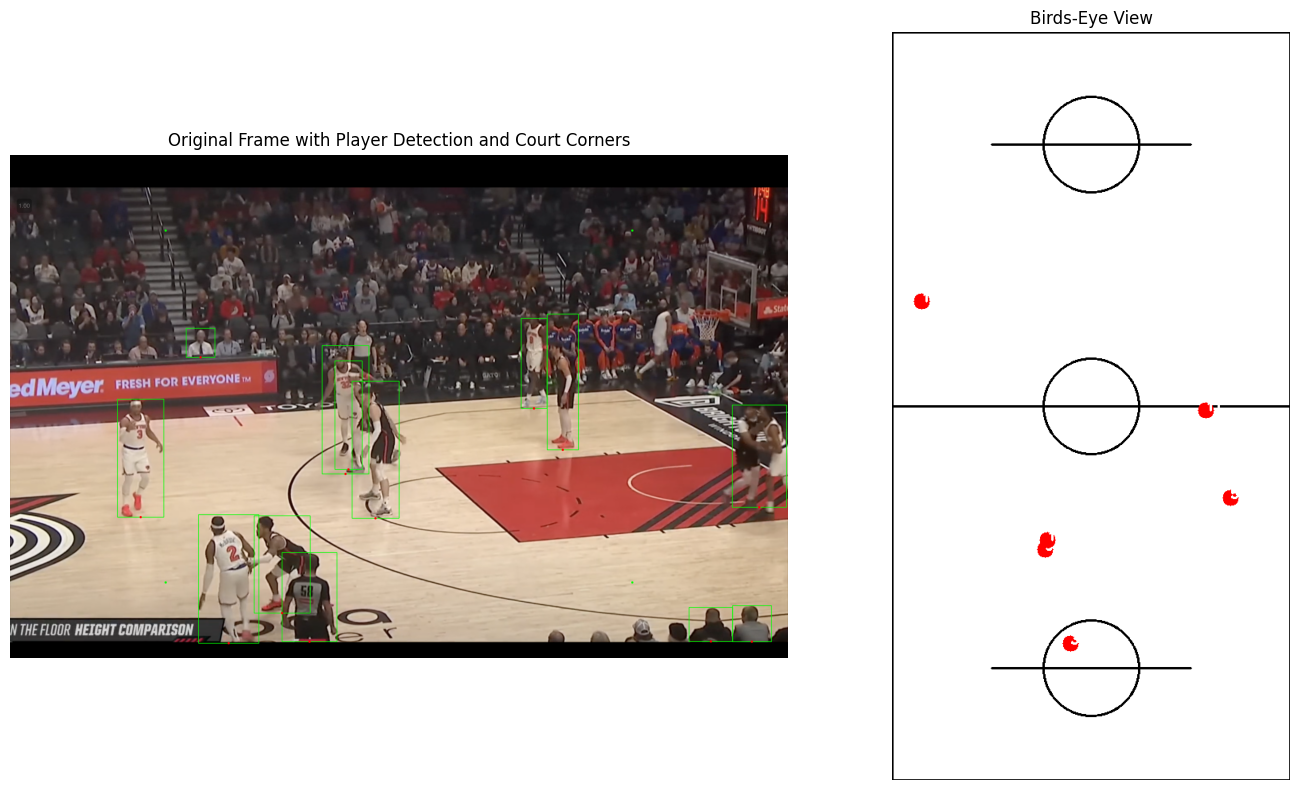

True

In [7]:
# 1. Load a video frame
frame = cv2.imread('basketball_frame.png')

# 2. Process the frame
original_with_detection, birds_eye = create_birds_eye_view(frame)

# 3. Display results
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title('Original Frame with Player Detection and Court Corners')
plt.imshow(cv2.cvtColor(original_with_detection, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Birds-Eye View')
plt.imshow(birds_eye)
plt.axis('off')

plt.tight_layout()
plt.show()

# Save output images
cv2.imwrite('player_detection.jpg', original_with_detection)
cv2.imwrite('birds_eye_view.jpg', birds_eye)